In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)
import os

# List the top-level files/folders
print(os.listdir(path))

Path to dataset files: /kaggle/input/face-expression-recognition-dataset
['images']


In [23]:
# 1. Create the improved model
def fe_model():
    model = tf.keras.models.Sequential([
        # First Conv Layer
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        
        # Second Conv Layer
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        
        # Third Conv Layer
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        
        # Fourth Conv Layer
        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        
        # Classifier
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    return model
    

In [24]:
# 2. Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1/255.0)


In [25]:
# 3. Create data generators with augmentation

train_dataset = train_datagen.flow_from_directory(
    "/kaggle/input/face-expression-recognition-dataset/images/images/train", 
    target_size=(48, 48),
    batch_size=32,  # Increased batch size
    color_mode='grayscale',
    class_mode='categorical'
)
validation_dataset = validation_datagen.flow_from_directory(
    "/kaggle/input/face-expression-recognition-dataset/images/images/validation",
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [26]:
# 4. Create and compile the improved model
model = fe_model()

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_fer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [27]:
# 5. Train the fe_model
print("Training model...")
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),  # Use all batches
    epochs=50,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    callbacks=callbacks,
    verbose=1
)

Training model...
Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2017 - loss: 2.5233
Epoch 1: val_accuracy improved from -inf to 0.25064, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 115s 122ms/step - accuracy: 0.2017 - loss: 2.5229 - val_accuracy: 0.2506 - val_loss: 1.7930 - learning_rate: 0.0010
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2380 - loss: 1.8320
Epoch 2: val_accuracy improved from 0.25064 to 0.28489, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.2380 - loss: 1.8320 - val_accuracy: 0.2849 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2634 - loss: 1.7817
Epoch 3: val_accuracy improved from 0.28489 to 0.30894, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.2634 - loss: 1.7817 - val_accuracy: 0.3089 - val_loss: 1.6980 - learning_rate: 0.0010
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2806 - loss: 1.7551
Epoch 4: val_accuracy did not improve from 0.30894
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.2806 - loss: 1.7551 - val_accuracy: 0.2850 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3086 - loss: 1.7162
Epoch 5: val_accuracy improved from 0.30894 to 0.37801, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.3086 - loss: 1.7162 - val_accuracy: 0.3780 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3274 - loss: 1.6811
Epoch 6: val_accuracy improved from 0.37801 to 0.41678, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 113s 125ms/step - accuracy: 0.3274 - loss: 1.6811 - val_accuracy: 0.4168 - val_loss: 1.5122 - learning_rate: 0.0010
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3454 - loss: 1.6539
Epoch 7: val_accuracy improved from 0.41678 to 0.46151, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 111s 123ms/step - accuracy: 0.3454 - loss: 1.6539 - val_accuracy: 0.4615 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3791 - loss: 1.5942
Epoch 9: val_accuracy did not improve from 0.47608
901/901 ━━━━━━━━━━━━━━━━━━━━ 112s 124ms/step - accuracy: 0.3791 - loss: 1.5942 - val_accuracy: 0.3912 - val_loss: 1.5220 - learning_rate: 0.0010
Epoch 10/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3814 - loss: 1.5750
Epoch 10: val_accuracy did not improve from 0.47608
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.3814 - loss: 1.5750 - val_accuracy: 0.4526 - val_loss: 1.4048 - learning_rate: 0.0010
Epoch 11/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3929 - loss: 1.5571
Epoch 11: val_accuracy improved from 0.47608 to 0.50283, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 110s 122ms/step - accuracy: 0.3929 - loss: 1.5571 - val_accuracy: 0.5028 - val_loss: 1.3265 - learning_rate: 0.0010
Epoch 12/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3965 - loss: 1.5426
Epoch 12: val_accuracy did not improve from 0.50283
901/901 ━━━━━━━━━━━━━━━━━━━━ 110s 123ms/step - accuracy: 0.3965 - loss: 1.5426 - val_accuracy: 0.4905 - val_loss: 1.3448 - learning_rate: 0.0010
Epoch 13/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4015 - loss: 1.5357
Epoch 13: val_accuracy improved from 0.50283 to 0.51585, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4015 - loss: 1.5357 - val_accuracy: 0.5159 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 14/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4086 - loss: 1.5237
Epoch 14: val_accuracy did not improve from 0.51585
901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.4086 - loss: 1.5237 - val_accuracy: 0.4997 - val_loss: 1.3186 - learning_rate: 0.0010
Epoch 15/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4131 - loss: 1.5144
Epoch 15: val_accuracy improved from 0.51585 to 0.51939, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4131 - loss: 1.5144 - val_accuracy: 0.5194 - val_loss: 1.2691 - learning_rate: 0.0010
Epoch 16/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4210 - loss: 1.4901
Epoch 16: val_accuracy improved from 0.51939 to 0.53651, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.4210 - loss: 1.4901 - val_accuracy: 0.5365 - val_loss: 1.2291 - learning_rate: 0.0010
Epoch 17/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4279 - loss: 1.4858
Epoch 17: val_accuracy did not improve from 0.53651
901/901 ━━━━━━━━━━━━━━━━━━━━ 110s 122ms/step - accuracy: 0.4279 - loss: 1.4858 - val_accuracy: 0.5197 - val_loss: 1.2521 - learning_rate: 0.0010
Epoch 18/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4362 - loss: 1.4668
Epoch 18: val_accuracy improved from 0.53651 to 0.54925, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 120ms/step - accuracy: 0.4362 - loss: 1.4668 - val_accuracy: 0.5492 - val_loss: 1.2016 - learning_rate: 0.0010
Epoch 19/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4431 - loss: 1.4540
Epoch 19: val_accuracy did not improve from 0.54925
901/901 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.4431 - loss: 1.4540 - val_accuracy: 0.5168 - val_loss: 1.2430 - learning_rate: 0.0010
Epoch 20/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4318 - loss: 1.4771
Epoch 20: val_accuracy did not improve from 0.54925
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4318 - loss: 1.4770 - val_accuracy: 0.5351 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 21/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4420 - loss: 1.4598
Epoch 21: val_accuracy did not improve from 0.54925
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4420 - loss: 1.4598 - val_accuracy: 0.5316 - val_loss: 1.2342 - learning_rate: 0.00

901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4669 - loss: 1.3986 - val_accuracy: 0.5693 - val_loss: 1.1428 - learning_rate: 0.0010
Epoch 30/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4647 - loss: 1.3968
Epoch 30: val_accuracy did not improve from 0.56935
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4647 - loss: 1.3968 - val_accuracy: 0.5204 - val_loss: 1.2722 - learning_rate: 0.0010
Epoch 31/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4712 - loss: 1.3885
Epoch 31: val_accuracy did not improve from 0.56935
901/901 ━━━━━━━━━━━━━━━━━━━━ 142s 122ms/step - accuracy: 0.4712 - loss: 1.3885 - val_accuracy: 0.5584 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 32/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4718 - loss: 1.3849
Epoch 32: val_accuracy did not improve from 0.56935
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4719 - loss: 1.3849 - val_accuracy: 0.5542 - val_loss: 1.1773 - learning_rate: 0.00

901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4761 - loss: 1.3777 - val_accuracy: 0.5743 - val_loss: 1.1411 - learning_rate: 0.0010
Epoch 34/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4776 - loss: 1.3651
Epoch 34: val_accuracy did not improve from 0.57430
901/901 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.4776 - loss: 1.3651 - val_accuracy: 0.5563 - val_loss: 1.1633 - learning_rate: 0.0010
Epoch 35/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4845 - loss: 1.3685
Epoch 35: val_accuracy improved from 0.57430 to 0.57586, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.4845 - loss: 1.3685 - val_accuracy: 0.5759 - val_loss: 1.1390 - learning_rate: 0.0010
Epoch 36/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4838 - loss: 1.3699
Epoch 36: val_accuracy did not improve from 0.57586
901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.4838 - loss: 1.3699 - val_accuracy: 0.5081 - val_loss: 1.2760 - learning_rate: 0.0010
Epoch 37/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4845 - loss: 1.3560
Epoch 37: val_accuracy improved from 0.57586 to 0.57671, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4845 - loss: 1.3560 - val_accuracy: 0.5767 - val_loss: 1.1359 - learning_rate: 0.0010
Epoch 38/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4847 - loss: 1.3509
Epoch 38: val_accuracy did not improve from 0.57671
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.4847 - loss: 1.3509 - val_accuracy: 0.5723 - val_loss: 1.1197 - learning_rate: 0.0010
Epoch 39/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4860 - loss: 1.3520
Epoch 39: val_accuracy did not improve from 0.57671
901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.4860 - loss: 1.3520 - val_accuracy: 0.5201 - val_loss: 1.2632 - learning_rate: 0.0010
Epoch 40/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4812 - loss: 1.3543
Epoch 40: val_accuracy did not improve from 0.57671
901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.4812 - loss: 1.3543 - val_accuracy: 0.5504 - val_loss: 1.1849 - learning_rate: 0.00

901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.4936 - loss: 1.3284 - val_accuracy: 0.5804 - val_loss: 1.1262 - learning_rate: 0.0010
Epoch 49/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5024 - loss: 1.3180
Epoch 49: val_accuracy improved from 0.58038 to 0.59029, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 107s 118ms/step - accuracy: 0.5024 - loss: 1.3180 - val_accuracy: 0.5903 - val_loss: 1.0976 - learning_rate: 2.0000e-04
Epoch 50/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5104 - loss: 1.2959
Epoch 50: val_accuracy improved from 0.59029 to 0.60204, saving model to best_fer_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.5104 - loss: 1.2959 - val_accuracy: 0.6020 - val_loss: 1.0520 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 50.


In [29]:
# Save the final trained model
model.save('fer_model_final.h5')
print("Model saved as 'fer_model_final.h5'")

# Also save in the newer Keras format
model.save('fer_model_final.keras')
print("Model saved as 'fer_model_final.keras'")

# Save model architecture as JSON
model_json = model.to_json()
with open("fer_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
    
# Save weights separately
model.save_weights('fer_model_weights.weights.h5')
print("Model weights saved as 'fer_model_weights.weights.h5'")

Model saved as 'fer_model_final.h5'
Model saved as 'fer_model_final.keras'
Model weights saved as 'fer_model_weights.weights.h5'


In [30]:
def real_time_fer_with_model(model):
    """
    Real-time recognition using a pre-loaded model
    """
    # Load face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    # Color mapping for different emotions
    emotion_colors = {
        'angry': (0, 0, 255),      # Red
        'disgust': (0, 128, 0),    # Dark Green
        'fear': (128, 0, 128),     # Purple
        'happy': (0, 255, 255),    # Yellow
        'neutral': (255, 255, 255), # White
        'sad': (255, 0, 0),        # Blue
        'surprise': (0, 165, 255)  # Orange
    }
    
    cam = cv2.VideoCapture(0)
    
    if not cam.isOpened():
        print("Error: Could not open camera")
        return
    
    print("\nReal-time Facial Expression Recognition (Using Saved Model)")
    print("Press 'q' to exit")
    
    while True:
        ret, frame = cam.read()
        if not ret:
            break
            
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5, minSize=(100, 100))
        
        for (x, y, w, h) in faces:
            try:
                face_roi = gray[y:y+h, x:x+w]
                face_roi = cv2.resize(face_roi, (48, 48))
                face_roi = face_roi.astype('float32') / 255.0
                face_roi = np.expand_dims(face_roi, axis=-1)
                face_roi = np.expand_dims(face_roi, axis=0)
                
                prediction = model.predict(face_roi, verbose=0)
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                emotion = emotions[predicted_class]
                color = emotion_colors[emotion]
                
                # Draw bounding box and label
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
                label_bg_height = 40
                cv2.rectangle(frame, (x, y-label_bg_height), (x+w, y), color, -1)
                cv2.putText(frame, f"{emotion} ({confidence:.2f})", 
                           (x+5, y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                
            except Exception as e:
                continue
        
        cv2.putText(frame, "Press 'q' to exit", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"Faces: {len(faces)}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('Facial Expression Recognition - Saved Model', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cam.release()
    cv2.destroyAllWindows()

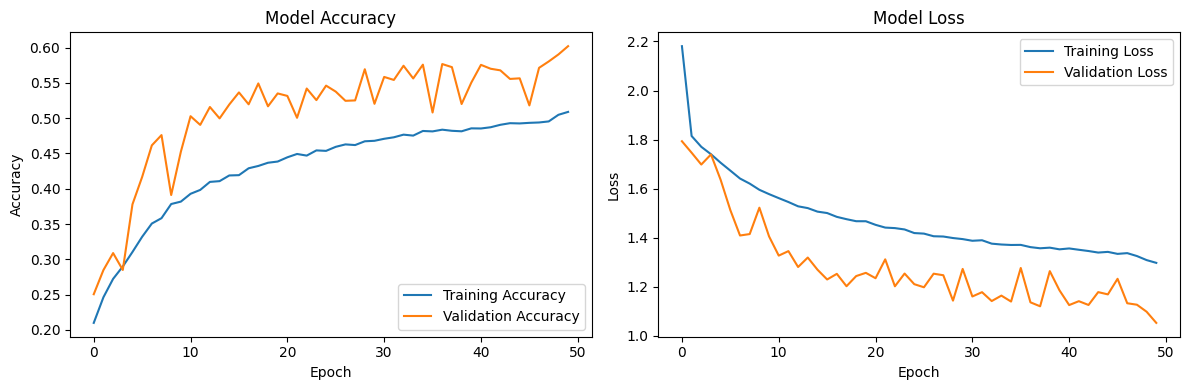

In [32]:
# 7. Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Model Evaluation:
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       960
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.05      0.07      1018
       happy       0.26      0.28      0.27      1825
     neutral       0.18      0.26      0.21      1216
         sad       0.16      0.17      0.17      1139
    surprise       0.12      0.13      0.12       797

    accuracy                           0.18      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.18      0.18      0.17      7066



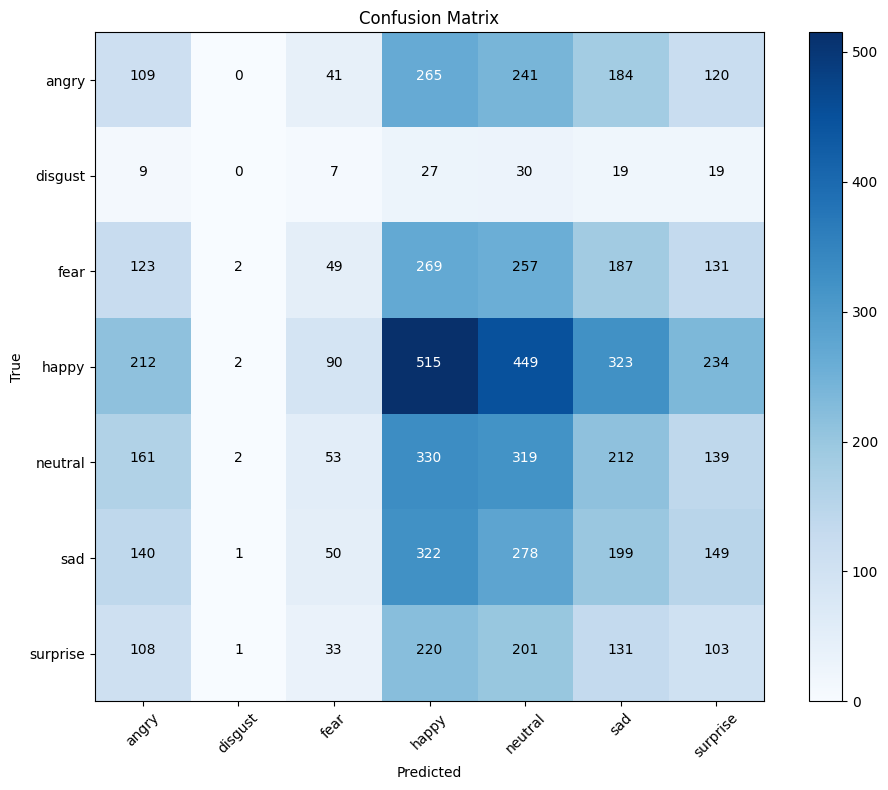

In [33]:
# 8. Evaluate the model
def evaluate_model(model, validation_dataset):
    # Get predictions
    predictions = model.predict(validation_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = validation_dataset.classes
    
    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=list(validation_dataset.class_indices.keys())))
    
    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(validation_dataset.class_indices))
    plt.xticks(tick_marks, validation_dataset.class_indices.keys(), rotation=45)
    plt.yticks(tick_marks, validation_dataset.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

# Evaluate the model
print("Model Evaluation:")
evaluate_model(model, validation_dataset)

In [35]:
def test_single_image(model, image_path):
    """
    Test the trained model on a single image
    """
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Load face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        if len(faces) == 0:
            print("No faces detected in the image!")
            # Try to use the entire image as a face
            face_roi = cv2.resize(gray, (48, 48))
            face_roi = face_roi.astype('float32') / 255.0
            face_roi = np.expand_dims(face_roi, axis=-1)
            face_roi = np.expand_dims(face_roi, axis=0)
            
            # Predict
            prediction = model.predict(face_roi, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            emotion = emotions[predicted_class]
            
            # Display results
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Predicted Emotion: {emotion} (Confidence: {confidence:.2f})')
            plt.axis('off')
            plt.show()
            
            print(f"Predicted Emotion: {emotion}")
            print(f"Confidence: {confidence:.2f}")
            print("Full predictions:", dict(zip(emotions, prediction[0])))
            
        else:
            # Process each detected face
            for i, (x, y, w, h) in enumerate(faces):
                # Extract and preprocess face
                face_roi = gray[y:y+h, x:x+w]
                face_roi = cv2.resize(face_roi, (48, 48))
                face_roi = face_roi.astype('float32') / 255.0
                face_roi = np.expand_dims(face_roi, axis=-1)
                face_roi = np.expand_dims(face_roi, axis=0)
                
                # Predict
                prediction = model.predict(face_roi, verbose=0)
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                emotion = emotions[predicted_class]
                
                # Draw bounding box and label on the image
                color = (0, 255, 0) if confidence > 0.5 else (0, 0, 255)
                cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
                cv2.putText(img, f"{emotion} ({confidence:.2f})", 
                           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                
                print(f"Face {i+1}: {emotion} (Confidence: {confidence:.2f})")
            
            # Display the image with predictions
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title('Facial Expression Recognition Results')
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Error processing image: {e}")

✅ Model loaded successfully!
Starting real-time recognition...
Face 1: surprise (Confidence: 0.33)
Face 2: fear (Confidence: 0.40)
Face 3: surprise (Confidence: 0.96)
Face 4: surprise (Confidence: 0.79)
Face 5: angry (Confidence: 0.32)
Face 6: happy (Confidence: 0.99)
Face 7: neutral (Confidence: 0.64)
Face 8: sad (Confidence: 0.42)
Face 9: angry (Confidence: 0.47)
Face 10: neutral (Confidence: 0.33)
Face 11: angry (Confidence: 0.57)
Face 12: neutral (Confidence: 0.44)
Face 13: surprise (Confidence: 0.49)
Face 14: sad (Confidence: 0.22)
Face 15: happy (Confidence: 0.43)


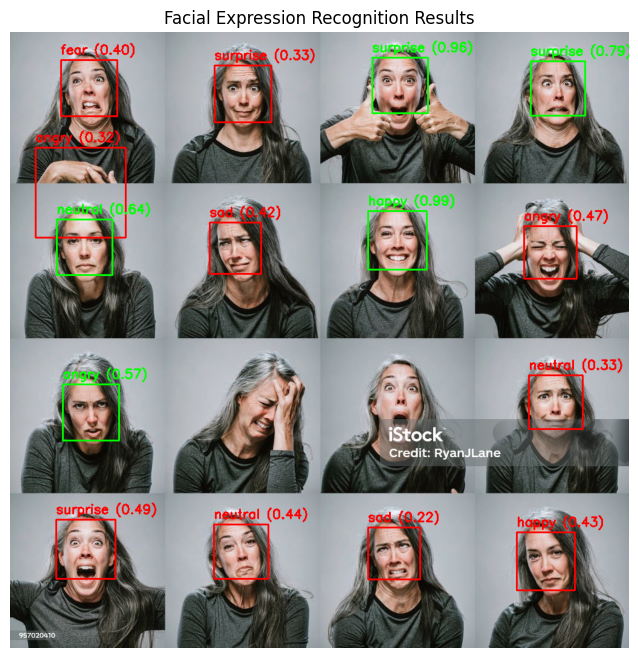

In [37]:
# A quick test of the model
def quick_test():
    """Quick test to verify everything works"""
    try:
        model = tf.keras.models.load_model('fer_model_final.h5')
        print("✅ Model loaded successfully!")
        print("Starting real-time recognition...")
        # real_time_fer_with_model(model)
        test_single_image(model, "/kaggle/input/testimage/istockphoto-957020410-1024x1024.jpg")
    except:
        print("❌ Model not found. Please train the model first.")

# Run this anytime to test
quick_test()